#Import packages.

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup             
import re
from nltk.corpus import stopwords # Import the stop word list
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt


In [2]:
train = pd.read_csv("labeledTrainData.tsv", header=0, \
                    delimiter="\t", quoting=3)


In [3]:
train.shape

(25000, 3)

#Dropping the 'ID' column.

In [4]:
train = train.drop(['id'], axis=1)

In [5]:
train.columns

Index(['sentiment', 'review'], dtype='object')

In [6]:
train.head()

,sentiment,review
0,1,"""With all this stuff going down at the moment ..."
1,1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,0,"""The film starts with a manager (Nicholas Bell..."
3,0,"""It must be assumed that those who praised thi..."
4,1,"""Superbly trashy and wondrously unpretentious ..."


In [7]:
train_2 = pd.read_csv('imdb_master.csv',encoding="latin-1")

In [8]:
train_2.shape

(100000, 5)

In [9]:
train_2.columns

Index(['Unnamed: 0', 'type', 'review', 'label', 'file'], dtype='object')

In [10]:
train_2.head()

,Unnamed: 0,type,review,label,file
0,0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


#Dropping the Unnamed 'ID' column, and file column.

In [11]:
train_2 = train_2.drop(['Unnamed: 0','type','file'], axis=1)


In [12]:
train_2.columns = ["review","sentiment"]
train_2.head()

,review,sentiment
0,Once again Mr. Costner has dragged out a movie...,neg
1,This is an example of why the majority of acti...,neg
2,"First of all I hate those moronic rappers, who...",neg
3,Not even the Beatles could write songs everyon...,neg
4,Brass pictures (movies is not a fitting word f...,neg


In [13]:
train_2['sentiment'].unique

<bound method Series.unique of 0          neg
1          neg
2          neg
3          neg
4          neg
         ...  
99995    unsup
99996    unsup
99997    unsup
99998    unsup
99999    unsup
Name: sentiment, Length: 100000, dtype: object>

#Removing the Undefied Sentiment 'unsup', convert positives & negatives into 1, 0

In [14]:
train_2 = train_2[train_2.sentiment != 'unsup']
train_2['sentiment'] = train_2['sentiment'].map({'pos': 1, 'neg': 0})
train_2.head()

,review,sentiment
0,Once again Mr. Costner has dragged out a movie...,0
1,This is an example of why the majority of acti...,0
2,"First of all I hate those moronic rappers, who...",0
3,Not even the Beatles could write songs everyon...,0
4,Brass pictures (movies is not a fitting word f...,0


In [15]:
train_2['sentiment'].unique

<bound method Series.unique of 0        0
1        0
2        0
3        0
4        0
        ..
49995    1
49996    1
49997    1
49998    1
49999    1
Name: sentiment, Length: 50000, dtype: int64>

#Joining two training sets

In [16]:
training = pd.concat([train, train_2]).reset_index(drop=True)
training.shape

(75000, 2)

In [17]:
# Get mean of positive and negative reviews
avg_pos_words = training[training.sentiment==1].review.apply(lambda x: len(x.split())).mean()
avg_neg_words = training[training.sentiment==0].review.apply(lambda x: len(x.split())).mean()

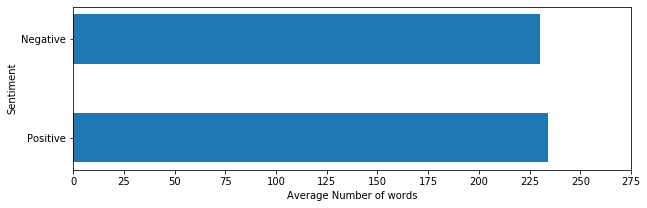

In [18]:
plt.figure(figsize=(10, 3))
plt.barh(['Positive', 'Negative'], [avg_pos_words, avg_neg_words], height=0.5)
plt.xticks(np.arange(0, 300, 25))
plt.xlabel('Average Number of words')
plt.ylabel('Sentiment')
plt.show()

#Data Cleaning and Text Preprocessing

In [19]:
def review_to_words( raw_review ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review,).get_text() 
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))  

In [20]:
num_reviews = training["review"].size

# Loop over each review; create an index i that goes from 0 to the length
# of the movie review list 
print ("Cleaning and parsing the training set movie reviews...\n")
clean_train_reviews = []
for i in range( 0, num_reviews ):
    # If the index is evenly divisible by 10000, print a message
    if( (i+1)%10000 == 0 ):
        print ("Review %d of %d\n" % ( i+1, num_reviews ))                                                                 
    clean_train_reviews.append( review_to_words( training["review"][i] ))
print("Done")

Cleaning and parsing the training set movie reviews...

Review 10000 of 75000

Review 20000 of 75000

Review 30000 of 75000

Review 40000 of 75000

Review 50000 of 75000

Review 60000 of 75000

Review 70000 of 75000

Done


#Creating Features from a Bag of Words (Using scikit-learn)

In [24]:
print ("Creating the bag of words...\n")
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 6000) 

# The input to fit_transform should be a list of strings.
train_data_features = vectorizer.fit_transform(clean_train_reviews)

# Numpy arrays are easy to work with, so convert the result to an 
# array
train_data_features = train_data_features.toarray()
print ("Done")

Creating the bag of words...

Done


#Creating a WordCloud


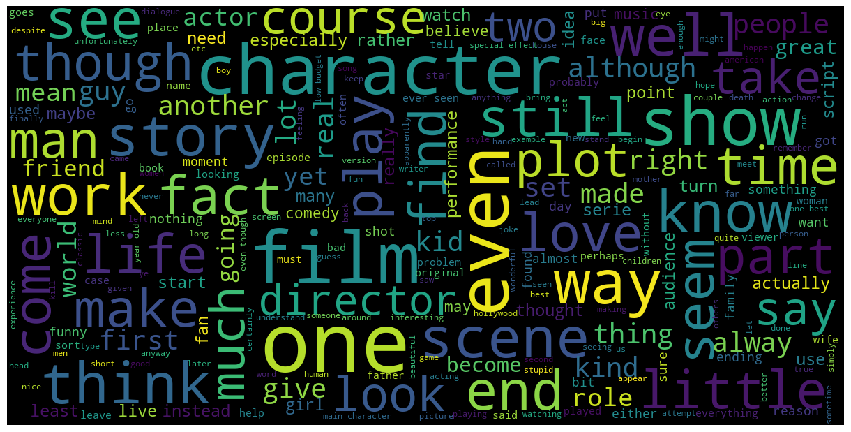

In [22]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=300,
        max_font_size=40, 
        scale=3,
        random_state=0 # chosen at random by flipping a coin; it was heads
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(clean_train_reviews)

#Splitting dataset into training and testing data

In [25]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train_data_features,training["sentiment"],test_size=0.2,random_state=0)
print("Splitting Done")

Splitting Done


#Training the data with Random Forest

In [27]:
from sklearn.ensemble import RandomForestClassifier

# Initialize a Random Forest classifier with 100 trees
forest = RandomForestClassifier(n_estimators = 500) 

# Fit the forest to the training set, using the bag of words as 
# features and the sentiment labels as the response variable
#
forest = forest.fit(x_train, y_train )
print ("Done")

Done


#Use the random forest to make sentiment label predictions

In [28]:
res = forest.predict(x_test)
print("Predictions Done")

Predictions Done


#Checking accuracy score

In [30]:
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix
accuracy=accuracy_score(y_test,res)
accuracy

0.9356

#Checking confusion matrix

In [31]:
cm=confusion_matrix(y_test,res,labels=[1,0])
cm

array([[7006,  511],
       [ 455, 7028]], dtype=int64)

Text(0.5, 1, 'Confusion matrix Random Forest')

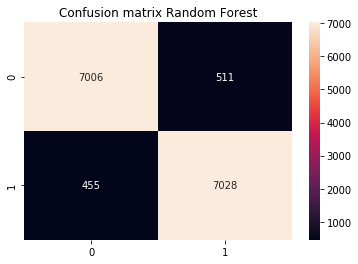

In [32]:
import seaborn as sns
# plot the confusion matrix
ax = plt.axes()
sns.heatmap(cm, annot=True, fmt="d")
ax.set_title('Confusion matrix Random Forest')


#Checking f1 score

In [33]:
f1=f1_score(y_test,res)
f1

0.9355054079316332

#Second Method

#TF-IDF

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [40]:
tfidf = TfidfVectorizer(
           ngram_range=(1, 3),  
           use_idf=1,
           smooth_idf=1,
           max_features=6000)

In [41]:
train_data_features = tfidf.fit_transform(clean_train_reviews)
# Numpy arrays are easy to work with, so convert the result to an array
train_data_features = train_data_features.toarray()
print ("Done")


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train_data_features,training["sentiment"],test_size=0.2,random_state=0)
print("Splitting Done")

In [ ]:
from sklearn.naive_bayes import MultinomialNB 

clf = MultinomialNB()
clf.fit(x_train, y_train)
pred = clf.predict(x_test)
print (pred)

In [ ]:
accuracy=accuracy_score(y_test,pred)

In [ ]:
print(accuracy)
#0.8668

In [ ]:
confusion_matrix_naive = confusion_matrix(y_test, pred, labels=[1,0])

In [ ]:
# plot the confusion matrix
import seaborn as sns
ax = plt.axes()
sns.heatmap(confusion_matrix_naive, annot=True, fmt="d")
ax.set_title('Confusion matrix Naive Bayes')